In [1]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper


def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    print(fcd.shape)
    print(data.shape)
    print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


In [128]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
triu_idx = np.triu_indices(C.shape[1],1)
brunout = 5
params = dmf.default_params(C=C)
params['N'] = C.shape[0]
params['seed'] = 2
sampling_freq = 10000

G_max = 5.5
DECAY_max = 60000
OBJ_RATE_max = 15
#G_step = 0.1
#DECAY_step = 0.2
G_step = 0.5
DECAY_step = 20000
OBJ_RATE_step = 3
G_range = np.arange(0,G_max,G_step)
DECAY_range =  [0,100,1000,5000,10000,20000,30000,40000,50000] #np.arange(1,DECAY_max,DECAY_step)
OBJ_RATE_range = [1,3.44,6.88,15,30] #np.arange(1,OBJ_RATE_max,OBJ_RATE_step)
LR_range = [0.1,0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,30,45,60,75,90,180] #np.arange(0,LR_max,LR_step)
# Define the number of cores to use
NUM_CORES = 16
#G_range = G_range[5:8]
#DECAY_range = DECAY_range[4:7]
#OBJ_RATE_range = OBJ_RATE_range[1:3]
#LR_range = LR_range[8:11]
amount_slow_regions_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range),len(LR_range)))
mean_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range),len(LR_range)))
std_slow_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range),len(LR_range)))
corr_to_sc_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range),len(LR_range)))
homeostatic_fittness_grid = np.zeros((len(G_range), len(DECAY_range),len(OBJ_RATE_range),len(LR_range)))
rates_grid = np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),len(LR_range),params['N']))
fic_t_grid = np.zeros((len(G_range),len(DECAY_range),len(OBJ_RATE_range),len(LR_range),params['N']))


In [129]:
def grid_step(args):
    G_tuple, DECAY_tuple, OBJ_RATE_tuple, LR_tuple = args
    idx_G,G = G_tuple[0],G_tuple[1]
    idx_DECAY,DECAY = DECAY_tuple[0],DECAY_tuple[1]
    idx_OBJ_RATE,OBJ_RATE = OBJ_RATE_tuple[0],OBJ_RATE_tuple[1]
    idx_LR,LR = LR_tuple[0],LR_tuple[1]
    print(f"Running - G:{G} / DECAY:{DECAY} / OBJ_RATE:{OBJ_RATE} / LR:{LR} \n")
    with_decay = DECAY>0
    params['lrj'] = LR
    params['G'] = G
    params['taoj'] = DECAY if with_decay else 10 # If 0 it means no plasticity at all. We put some value so it does not crash
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    rates, rates_inh, _, fic_t = dmf.run(params, nb_steps,
                                            return_rate=True, return_bold=False, return_fic=True, 
                                            with_decay=with_decay, with_plasticity=True)        
    rates = rates[:, np.ceil(brunout * 1000).astype(int):]
    rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
    fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
    rates_fc = np.corrcoef(rates)
    power_spectrum,frequencies = psd_array_multitaper(rates, verbose=False,sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
    # Embedded array whose first elemnt is the index of the first number equal or greater then 4 or 1
    four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
    one_idx_freq = np.where(frequencies >= 1)[0][0]
    plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)                                        

    amount_slow_regions = np.sum(plow_ptot>0.3)
    mean_slow = np.mean(plow_ptot)
    std_slow = np.std(plow_ptot)
    corr_to_sc = pearsonr(rates_fc[triu_idx[0],triu_idx[1]], C[triu_idx[0],triu_idx[1]])[0]

    homeostatic_fittness =  OBJ_RATE - np.mean(rates)  
    return idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR, amount_slow_regions,mean_slow, std_slow,corr_to_sc ,homeostatic_fittness,np.mean(rates,axis=1),np.mean(fic_t,axis=1)


##  Grid seacrch


In [130]:
from multiprocessing import Pool,Manager


# Define the number of cores to use

# Create a list of argument tuples for the nested loop function
args_list = [((idx_G,G), (idx_DECAY,DECAY), (idx_OBJ_RATE,OBJ_RATE), (idx_LR,LR))
             for idx_G,G in enumerate(G_range)
             for idx_DECAY,DECAY in enumerate(DECAY_range)
             for idx_OBJ_RATE,OBJ_RATE in enumerate(OBJ_RATE_range)
             for idx_LR,LR in enumerate(LR_range)]

manager = Manager()
results_list = manager.list()
# Create a pool of worker processes
with Pool(processes=NUM_CORES) as pool:
    # Map the nested loop function to the argument list across multiple processes
    results_list.extend(pool.map(grid_step, args_list))



Running - G:0.0 / DECAY:10000 / OBJ_RATE:15 / LR:1 
Running - G:0.0 / DECAY:0 / OBJ_RATE:1 / LR:0.1 
Running - G:0.0 / DECAY:100 / OBJ_RATE:6.88 / LR:15 
Running - G:0.0 / DECAY:5000 / OBJ_RATE:1 / LR:8 
Running - G:0.0 / DECAY:30000 / OBJ_RATE:3.44 / LR:0.3 
Running - G:0.5 / DECAY:0 / OBJ_RATE:3.44 / LR:10 
Running - G:0.0 / DECAY:40000 / OBJ_RATE:15 / LR:45 

Running - G:0.5 / DECAY:100 / OBJ_RATE:30 / LR:3 






Running - G:0.5 / DECAY:5000 / OBJ_RATE:6.88 / LR:0.5 
Running - G:1.0 / DECAY:1000 / OBJ_RATE:1 / LR:180 
Running - G:0.5 / DECAY:50000 / OBJ_RATE:1 / LR:5 

Running - G:1.0 / DECAY:0 / OBJ_RATE:15 / LR:0.7 
Running - G:0.5 / DECAY:30000 / OBJ_RATE:6.88 / LR:12 
Running - G:0.5 / DECAY:10000 / OBJ_RATE:30 / LR:75 




Running - G:1.0 / DECAY:5000 / OBJ_RATE:15 / LR:14 
Running - G:1.0 / DECAY:20000 / OBJ_RATE:3.44 / LR:7 




Running - G:0.5 / DECAY:50000 / OBJ_RATE:1 / LR:6 

Running - G:1.0 / DECAY:5000 / OBJ_RATE:15 / LR:15 

Running - G:0.0 / DECAY:40000 / OBJ_RATE:15

In [136]:
results_list

<ListProxy object, typeid 'list' at 0x7f859576e190>

In [137]:
for results in results_list:
    idx_G = results[0]
    idx_DECAY = results[1]
    idx_OBJ_RATE = results[2]
    idx_LR = results[3]
    amount_slow_regions = results[4]
    mean_slow = results[5]
    std_slow = results[6]
    corr_to_sc = results[7]
    homeostatic_fittness = results[8]
    rates = results[9]
    fic_t = results[10]
    amount_slow_regions_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR] = amount_slow_regions
    mean_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR] = mean_slow
    std_slow_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR] = std_slow
    corr_to_sc_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR] = corr_to_sc
    homeostatic_fittness_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR] = homeostatic_fittness
    rates_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR,:] = rates
    fic_t_grid[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR,:] = fic_t

In [138]:
homeostatic_fittness_grid[0,0,0,:]

array([-1.98080654, -1.72576864, -1.53877016, -1.39252036, -1.27329977,
       -1.1732748 , -1.0875337 , -1.01281663, -0.94684387, -0.88796215,
       -0.5143192 , -0.31635475, -0.18897449, -0.09864623, -0.03068474,
        0.02254327,  0.06546749,  0.10085575,  0.13054474,  0.15580605,
        0.17755125,  0.19645339,  0.2130224 ,  0.22765134,  0.33494405,
        0.36968449,  0.38547514,  0.39403326,  0.39918893,  0.40898091])

In [139]:
import os

# Assuming these arrays are already populated with data

arrays_to_save = {
    'amount_slow_regions_grid': amount_slow_regions_grid,
    'mean_slow_grid': mean_slow_grid,
    'std_slow_grid': std_slow_grid,
    'corr_to_sc_grid': corr_to_sc_grid,
    'homeostatic_fittness_grid': homeostatic_fittness_grid,
    'rates_grid': rates_grid,
    'fic_t_grid': fic_t_grid
}

results_folder = "./Results"

for array_name, array_data in arrays_to_save.items():
    file_name = os.path.join(results_folder, f"{array_name}.npy")
    np.save(file_name, array_data)


In [ ]:
#[idx_G, idx_DECAY,idx_OBJ_RATE,idx_LR,:]

In [151]:
min_idx = np.unravel_index(np.argmin(homeostatic_fittness_grid[:, i, j, :]), homeostatic_fittness_grid[:, i, j, :].shape)

In [256]:
params['N'] = 90

In [257]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

idx_OBJ_RATE = 1

for i, DECAY_value in enumerate(DECAY_range):
    for j, OBJ_RATE_value in enumerate(OBJ_RATE_range):
        fig, axs = plt.subplots(3, 2, figsize=(15, 10))
        plt.axis('off')
        ax = axs[0,0 ]  # Get the correct axis
        slice_data = homeostatic_fittness_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='coolwarm', aspect='auto', vmin=-OBJ_RATE_value/2, vmax=OBJ_RATE_value/2)
                            #norm=SymLogNorm(linthresh=3, linscale=1,vmin=-np.max(slice_data), vmax=np.max(slice_data)))
        plt.colorbar(heatmap, ax=ax),#ticks=np.linspace(np.min(slice_data), np.max(slice_data), 6))            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'Homeostatic fittness')

        ax = axs[0,1]  # Get the correct axis
        slice_data = corr_to_sc_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='hot', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'corr_to_sc')

        ax = axs[1,0]  # Get the correct axis
        slice_data = mean_slow_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='plasma', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'mean_plow/ptot')

        ax = axs[1,1]  # Get the correct axis
        slice_data = std_slow_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='plasma', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'std_plow/ptot')

        ax = axs[2,0]  # Get the correct axis
        slice_data = amount_slow_regions_grid[:, i,j,:]
        heatmap = ax.imshow(slice_data, cmap='viridis', aspect='auto', vmin=np.min(slice_data), vmax=np.max(slice_data))
        plt.colorbar(heatmap, ax=ax)            
        # Set x and y tick labels
        ax.set_xlabel('LR_rand')
        ax.set_ylabel('G_range')            
        # Set x and y ticks using LR_range and G_range respectively
        ax.set_xticks(range(len(LR_range)))
        ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
        ax.set_yticks(range(len(G_range)))
        ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
        ax.set_title(f'amount_slow_regions')

        ax = axs[2,1]
        min_idx = np.unravel_index(np.argmin(np.abs(homeostatic_fittness_grid[:, i, j, :])), homeostatic_fittness_grid[:, i, j, :].shape)
        ax.bar(np.arange(params['N']), rates_grid[min_idx[0],i,j,min_idx[1],:], edgecolor='none')
        ax.plot([0, params['N'] + 1], [OBJ_RATE_value, OBJ_RATE_value], 'r--')
        ax.set_ylabel('E Firing Rate (Hz)')
        ax.set_xlabel('Regions')
        ax.set_title(f'Hom Fit: {np.min(np.abs(homeostatic_fittness_grid[:, i, j, :])):.2f}\nG={G_range[min_idx[0]]} LR={LR_range[min_idx[1]]}')
        

        plt.tight_layout()
        plt.savefig(f'./heatmaps/DECAY_{DECAY_value}_OBJ_RATE_{OBJ_RATE_value}.png')  # Save the plot
        plt.close()


### One Run Sanity Check

In [263]:
OBJ_RATE = 3.44
def get_indices_of_values(G,DECAY,OBJ_RATE,LR):
    idx_G = np.where(np.array(G_range) == G)[0]
    idx_DECAY = np.where(np.array(DECAY_range) == DECAY)[0]
    idx_OBJ_RATE = np.where(np.array(OBJ_RATE_range) == OBJ_RATE)[0]
    idx_LR = np.where(np.array(LR_range) == LR)[0]
    print([idx_G,idx_DECAY,idx_OBJ_RATE,idx_LR])
    return [idx_G,idx_DECAY,idx_OBJ_RATE,idx_LR]
idxs = get_indices_of_values(20, 1000,OBJ_RATE,300)


[array([], dtype=int64), array([2]), array([1]), array([], dtype=int64)]


Text(0.5, 1.0, 'Homeostatic fittness')

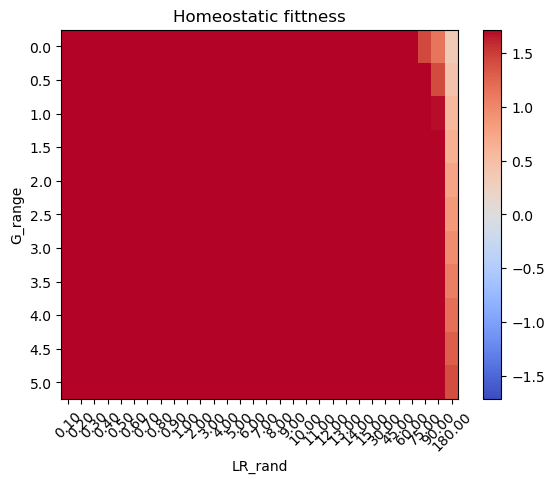

In [247]:
slice_data = homeostatic_fittness_grid[:,idxs[1][0],idxs[2][0],:]
fig,ax = plt.subplots()
heatmap = ax.imshow(slice_data, cmap='coolwarm', aspect='auto', vmin=-OBJ_RATE/2,vmax=OBJ_RATE/2)
                    #norm=SymLogNorm(linthresh=3, linscale=1,vmin=np.min(slice_data), vmax=np.max(slice_data)))
plt.colorbar(heatmap, ax=ax),#ticks=np.linspace(np.min(slice_data), np.max(slice_data), 6))            
# Set x and y tick labels
ax.set_xlabel('LR_rand')
ax.set_ylabel('G_range')            
# Set x and y ticks using LR_range and G_range respectively
ax.set_xticks(range(len(LR_range)))
ax.set_xticklabels([f'{value:.2f}' for value in LR_range], rotation=45)            
ax.set_yticks(range(len(G_range)))
ax.set_yticklabels([f'{value:.1f}' for value in G_range])            
ax.set_title(f'Homeostatic fittness')

In [248]:
homeostatic_fittness_grid[0,idxs[1][0],idxs[2][0],-1]

0.3464334217845022

In [229]:
homeostatic_fittness_grid[:,idxs[1][0],idxs[2][0],:]

array([[ -36.64667507,  -36.4949525 ,  -36.34460672,  -36.19561868,
         -36.04796966,  -35.9016413 ,  -35.75661559,  -35.61287482,
         -35.47040164,  -35.32917898,  -33.98219071,  -32.74358154,
         -31.60053383,  -30.54219079,  -29.55929277,  -28.64389212,
         -27.78912739,  -26.98904287,  -26.2384432 ,  -25.53277524,
         -24.86803134,  -24.24066977,  -23.64754865,  -23.08587092,
         -17.19666862,  -13.86528238,  -11.69767799,  -10.162211  ,
          -9.01066928,   -5.48170736],
       [ -49.94825755,  -49.73614607,  -49.52597897,  -49.31772898,
         -49.11136934,  -48.90687382,  -48.70421664,  -48.50337253,
         -48.30431667,  -48.1070247 ,  -46.22606662,  -44.49772407,
         -42.90376448,  -41.42878028,  -40.05965859,  -38.7851663 ,
         -37.5956225 ,  -36.48263727,  -35.43890181,  -34.45801841,
         -33.53436164,  -32.66296442,  -31.83942366,  -31.05982188,
         -22.90767154,  -18.32433042,  -15.36007839,  -13.27172059,
         

In [272]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)

#idx_G = idxs[0][0]
#idx_DECAY = idxs[1][0]
#idx_OBJ_RATE = idxs[2][0]
#idx_LR = idxs[3][0]
#params['seed'] = 2
params['G'] = 4#G_range[idx_G]
params['lrj'] = 6#LR_range[idx_LR]
params['obj_rate'] = OBJ_RATE_range[idx_OBJ_RATE]
params['taoj'] = 50000#DECAY_range[idx_DECAY]
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]

with_decay = True
with_plasticity = True
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)
# displaying the memory
#rates = rates_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
#rates_inh = rates_inh_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
#fic_t = fic_t_grid[idx_G, idx_DECAY, idx_OBJ_RATE]
brunout = 5
# Slicing and computations
bold = np.random.rand(N, 150)# bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
T = len(bold.T)
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)


# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))



(4005, 119)
(150, 90)
(31, 90)
    Using multitaper spectrum estimation with 30 DPSS windows


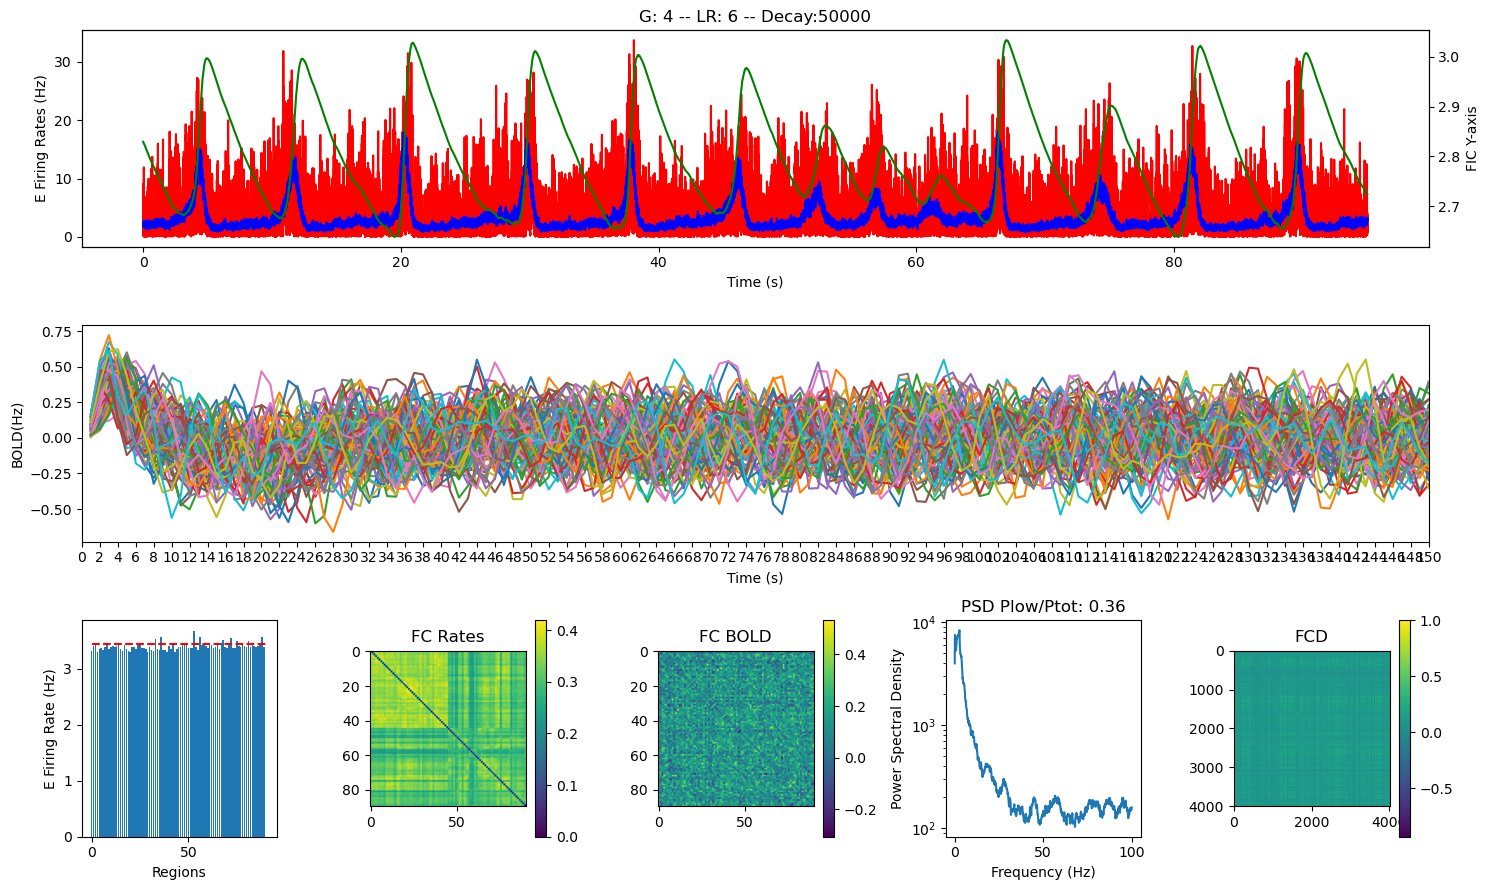

In [279]:
fig = plt.figure(figsize=(15, 9))
plt.axis('off')
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")

sel_t = np.arange(1,rates.shape[1] +1 )#np.arange(9000, 19000)   # 
sel_t_bold = np.arange(1, bold.shape[1] + 1)

four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)                                        
slowest_reg = np.argmin(plow_ptot)

plt.subplot(3, 1, 1)
plt.plot(sel_t * 0.001, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t * 0.001, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.001, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)

plt.semilogy(frequencies, power_spectrum[slowest_reg,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[slowest_reg, one_idx_freq:four_idx_freq])/np.sum(power_spectrum[slowest_reg,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()
